In [1]:
# Install required packages
!pip install matplotlib ipython numpy pandas statsmodels scipy seaborn pyhpo

In [39]:
# Import the required packages

# Figures
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

# Ipython notebook basics
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.setrecursionlimit(5000)

# Things I use everytime
import numpy as np
np.random.seed(42)
import pandas as pd
#import scipy.stats as stats

import statsmodels.api as sm
import re
import seaborn as sns

import scipy.stats as stats

In [3]:
# Parameter tagged cell for papermill
filename = "default"
#iso_seq_gene = pd.read_csv(f"/mmfs1/gscratch/stergachislab/yhhc/projects/Iso-seq_public/Cyclo_noncyclo_comparison/Analysis/6.10.24/3.Compare_samples/3.Novel_iso_abundance_in_gene/data_combined_full_gene_with_Hyp5.csv",sep=",")
#iso_seq_gene = pd.read_csv(f"/mmfs1/gscratch/stergachislab/yhhc/projects/Iso-seq_public/Cyclo_noncyclo_comparison/Analysis/6.10.24/3.Compare_samples/1.Isoform/data_combined_full.csv",sep=",")


In [5]:
iso_seq_gene = pd.read_csv(filename,sep=",")
#iso_seq_gene = pd.read_csv(f"/mmfs1/gscratch/stergachislab/yhhc/projects/Iso-seq_public/Cyclo_noncyclo_comparison/Analysis/6.10.24/3.Compare_samples/3.Novel_iso_abundance_in_gene/data_combined_full_gene_with_Hyp5.csv",sep=",")


/tmp/ipykernel_1644/427166940.py:1: DtypeWarning: Columns (37,38,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  iso_seq_gene = pd.read_csv(filename,sep=",")


In [6]:
# Remove isoforms with low counts in all patients.

# Define count threshold
count_threshold = 10

# Group by 'Isoform_PBid' and check if any counts meet the threshold
isoforms_to_keep = iso_seq_gene.groupby('Isoform_PBid').apply(
    lambda group: any(group['cyclo_count'] >= count_threshold) or any(group['noncyclo_count'] >= count_threshold)
)

# Filter to keep only isoforms that meet the threshold
isoforms_to_keep = isoforms_to_keep[isoforms_to_keep].index.tolist()

# Print helpful statements
print("Number of isoforms to keep after filtering based on counts:")
print(len(isoforms_to_keep))

# Filter the data_with_totals to keep only the desired Isoform_PBid
iso_seq_gene = iso_seq_gene[iso_seq_gene['Isoform_PBid'].isin(isoforms_to_keep)]


/tmp/ipykernel_1644/2184626134.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  isoforms_to_keep = iso_seq_gene.groupby('Isoform_PBid').apply(


Number of isoforms to keep after filtering based on counts:
186466


In [7]:

df = iso_seq_gene

# Function to calculate the test statistic for each isoform group
def calculate_test_statistic(group):
    results = []
    for index, row in group.iterrows():
        # Calculate mean, max, and min TPM for all other samples
        other_samples = group.drop(index)
        #mean_cyclo_TPM = other_samples['Cyclo_TPM'].mean()
        max_cyclo_TPM = other_samples['Cyclo_TPM'].max()
        #min_noncyclo_TPM = other_samples['Noncyclo_TPM'].min()

        median_cyclo_TPM = other_samples['Cyclo_TPM'].median()
        
        # Calculate the test statistic for LOE
        # test_statistic = (min_noncyclo_TPM / (row['Noncyclo_TPM']+1))

        # df['ratio'] = (min_noncyclo_TPM / (row['Noncyclo_TPM']+1))
        # df['ratio'] = (row['Noncyclo_TPM'])  / (min_noncyclo_TPM + 1)

        #How many times bigger is the minimum of the controls compared to the patient of interest.
        # Only the patient with the minimum expression will have a positive ratio.
        # A negative test statistic is when the control has a smaller minimum than the patient. 
        # There should be more negative test statistics because for each isoform, only 1 will have a positive test statistic. 
        ratio =  (row['Cyclo_TPM'] + 1)  / (max_cyclo_TPM + 1)
        test_statistic = np.log2(ratio) * np.log2( median_cyclo_TPM + 2)

        
        # if row['Noncyclo_TPM'] >= mean_noncyclo_TPM:
        #     # For genes that are greater than the mean, how much greater than the max is the sample of interest.
        #     test_statistic = row['Noncyclo_TPM'] / (max_noncyclo_TPM+1)
        # else:
        #     # For genes that are smaller than the mean, how much lower than the minimum is the sample interest.
        #     test_statistic = -(min_noncyclo_TPM / (row['Noncyclo_TPM']+1))
        
        results.append(test_statistic)
    
    group['test_statistic'] = results
    return group

# Apply the function to each isoform group
df = df.groupby('Isoform_PBid').apply(calculate_test_statistic)

# Reset the index to remove 'Isoform' as an index level
df = df.reset_index(drop=True)

/tmp/ipykernel_1644/1042660962.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Isoform_PBid').apply(calculate_test_statistic)


In [8]:
# Calculate z-score, compares patient to other patients.

# Function to calculate the z-score for each row within a group
def calculate_z_score_within_group(group):
    group = group.copy()  # Avoid SettingWithCopyWarning
    for i, row in group.iterrows():
        other_test_statistics = group.loc[group.index != i, 'test_statistic']
        median_others = other_test_statistics.median()
        sd_all = group['test_statistic'].std()

        if sd_all == 0:
            group['z_score'] = 0
        else:
            group.at[i, 'z_score'] = (row['test_statistic'] - median_others) / sd_all
            # Can't use IQR because iqr is 0 for the HARS1 positive control case and causes division by zero. 
    
    return group

# Function to calculate the z-score for each row within a group using median and IQR. Using median and IQR because the test statistic doesn't look
# normally distributed. 
# Function to calculate the z-score for each row within a group using median and IQR
# def calculate_z_score_within_group(group):
#     group = group.copy()  # Avoid SettingWithCopyWarning
#     for i, row in group.iterrows():
#         other_test_statistics = group.loc[group.index != i, 'test_statistic']
#         median_others = other_test_statistics.median()
#         iqr_all = np.percentile(group['test_statistic'], 75) - np.percentile(group['test_statistic'], 25)
        
#         # Prevent division by zero
#         if iqr_all == 0:
#             iqr_all = 1e-10
        
#         group.at[i, 'z_score'] = (row['test_statistic'] - median_others) / iqr_all
#     return group

# Apply the function to each group
df = df.groupby('Isoform_PBid').apply(calculate_z_score_within_group)

# Reset index to clean up the DataFrame
df.reset_index(drop=True, inplace=True)


#[T1 - mean(T2,...,T18)]/SD(T1,....,T18)

/tmp/ipykernel_1644/1164259836.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Isoform_PBid').apply(calculate_z_score_within_group)


## Histogram of test statistic

(array([2.000000e+00, 1.000000e+00, 3.000000e+00, 1.000000e+00,
        2.000000e+00, 7.000000e+00, 1.400000e+01, 1.500000e+01,
        3.200000e+01, 4.100000e+01, 7.800000e+01, 1.170000e+02,
        1.870000e+02, 3.000000e+02, 5.040000e+02, 8.580000e+02,
        1.364000e+03, 2.437000e+03, 4.244000e+03, 7.968000e+03,
        1.540200e+04, 2.964100e+04, 6.123100e+04, 1.397390e+05,
        4.197180e+05, 2.412749e+06, 2.326980e+05, 1.800400e+04,
        4.974000e+03, 1.745000e+03, 8.330000e+02, 4.510000e+02,
        2.820000e+02, 1.730000e+02, 1.220000e+02, 8.200000e+01,
        6.400000e+01, 5.700000e+01, 3.800000e+01, 3.500000e+01,
        2.900000e+01, 2.400000e+01, 1.700000e+01, 1.500000e+01,
        1.500000e+01, 8.000000e+00, 7.000000e+00, 6.000000e+00,
        4.000000e+00, 6.000000e+00, 1.000000e+01, 4.000000e+00,
        4.000000e+00, 2.000000e+00, 4.000000e+00, 3.000000e+00,
        3.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 3.000000e+00, 1.00

Text(0.5, 0, 'Test Statistic')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Test Statistic Values')

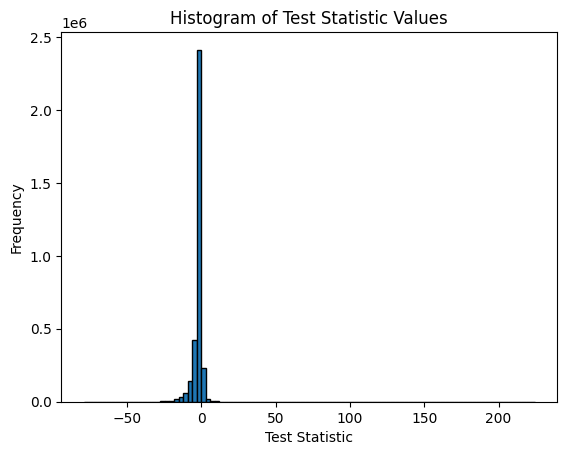

In [9]:
# Drop NaN values from the test_statistic column for plotting
test_statistic_values = df['test_statistic'].dropna()

# Create a histogram of the test_statistic values
plt.hist(test_statistic_values, bins=100, edgecolor='black')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Histogram of Test Statistic Values')
plt.show()

(array([2.000000e+00, 1.000000e+00, 3.000000e+00, 1.000000e+00,
        2.000000e+00, 7.000000e+00, 1.400000e+01, 1.500000e+01,
        3.200000e+01, 4.100000e+01, 7.800000e+01, 1.170000e+02,
        1.870000e+02, 3.000000e+02, 5.040000e+02, 8.580000e+02,
        1.364000e+03, 2.437000e+03, 4.244000e+03, 7.968000e+03,
        1.540200e+04, 2.964100e+04, 6.123100e+04, 1.397390e+05,
        4.197180e+05, 2.412749e+06, 2.326980e+05, 1.800400e+04,
        4.974000e+03, 1.745000e+03, 8.330000e+02, 4.510000e+02,
        2.820000e+02, 1.730000e+02, 1.220000e+02, 8.200000e+01,
        6.400000e+01, 5.700000e+01, 3.800000e+01, 3.500000e+01,
        2.900000e+01, 2.400000e+01, 1.700000e+01, 1.500000e+01,
        1.500000e+01, 8.000000e+00, 7.000000e+00, 6.000000e+00,
        4.000000e+00, 6.000000e+00, 1.000000e+01, 4.000000e+00,
        4.000000e+00, 2.000000e+00, 4.000000e+00, 3.000000e+00,
        3.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 3.000000e+00, 1.00

Text(0.5, 0, 'Test Statistic')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Zoomed in Histogram of Test Statistic Values')

(-3.0, 3.0)

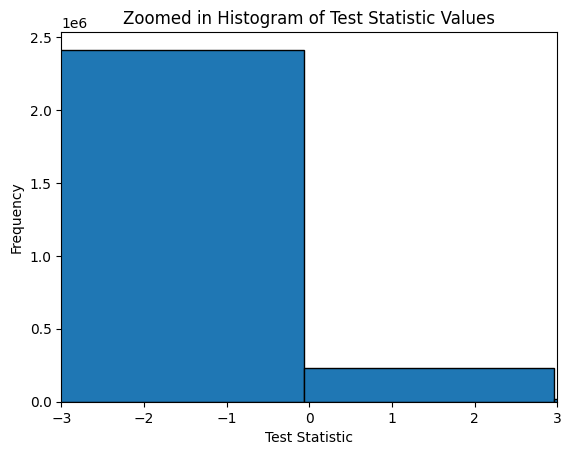

In [10]:
plt.hist(test_statistic_values, bins=100, edgecolor='black')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Zoomed in Histogram of Test Statistic Values')
plt.xlim(-3, 3)  # Set x-axis range from -25 to 25
plt.show()

## Summary stats of test statistic

In [11]:
# Drop NaN values from the test_statistic column
test_statistic_values = df['test_statistic'].dropna() # NA occurs when the abs diff is 0 and you take log2(0)

# Get summary statistics
summary_stats = test_statistic_values.describe()
summary_stats

count    3.356388e+06
mean    -2.148499e+00
std      3.248624e+00
min     -7.890440e+01
25%     -2.606269e+00
50%     -1.271381e+00
75%     -5.652318e-01
max      2.243161e+02
Name: test_statistic, dtype: float64

In [12]:
# # The amount of NAs should equal the amount of rows with abs diff of 0. LEFT OFF HERE
# num_na_values = df['test_statistic'].isna().sum()

# # Count the number of rows where absolute_diff is zero
# num_abs_diff_zero = (df['absolute_diff'] == 0).sum()

# print("\nNumber of NaN values in test_statistic:", num_na_values)
# print("Number of rows with absolute_diff equal to 0:", num_abs_diff_zero)

In [13]:
# Get the row with the max test_statistic
max_test_statistic_row = df.loc[df['test_statistic'].idxmax()]

# Get the row with the min test_statistic
min_test_statistic_row = df.loc[df['test_statistic'].idxmin()]

max_min_test_statistic_df = pd.DataFrame([max_test_statistic_row, min_test_statistic_row])

# Set display options to show all columns
pd.set_option('display.max_columns', None)

max_min_test_statistic_df

# Reset to default after displaying
pd.reset_option('display.max_columns')

,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,Max_P_Value_Hyp2_above_median,Max_P_Value_Hyp3_below_median,Max_P_Value_Hyp3_above_median,cyclo_total_sum,noncyclo_total_sum,CycloFraction,NoncycloFraction,Cyclo_TPM,Noncyclo_TPM,NormalizedCycloFraction,NormalizedNoncycloFraction,NormalizedFractionDifference,Avg_Cyclo_TPM,Avg_Noncyclo_TPM,gene_cyclo_total,gene_noncyclo_total,isoform_cyclo_proportion,isoform_noncyclo_proportion,SD_Cyclo_TPM,SD_Noncyclo_TPM,Cyclo_Z_Score,Noncyclo_Z_Score,MedianCyclo_TPM,MedianNoncyclo_TPM,Cyclo_TPM_Rank,Noncyclo_TPM_Rank,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,test_statistic,z_score
1666832,PB.171569.23,UDN318336,65014,312267,full-splice_match,TMSB4X,ENST00000451311.7,alternative_5end,0.0,NaN,0.0,NaN,0.000000e+00,23180599,34005649,0.002805,0.009183,2804.672994,9182.797835,0.233967,0.766033,-0.532066,156.051022,510.431640,73616,350181,0.883150,0.891730,661.008990,2164.337291,4.006938,4.006938,0.157305,0.363467,18.0,18.0,chrX,12975110,12977223,Xq21.3-q22,Xp22.2,300159,"""TMSB4X, TMSB4, TB4X, PTMB4""","""Thymosin, beta-4, X chromosome""",7114,ENSG00000205542,NaN,NaN,Tmsb4x (MGI:99510),False,224.316107,4.240260
1135634,PB.149998.4170,UDN318336,99854,3851,full-splice_match,COL1A1,ENST00000225964.10,alternative_3end,0.0,2.477524e-266,NaN,NaN,4.497343e-09,23180599,34005649,0.004308,0.000113,4307.654000,113.245890,0.974384,0.025616,0.948768,3498.292913,4019.964826,164584,150698,0.606705,0.025554,2584.123496,3252.531185,0.313205,-1.201132,3821.002003,3649.494416,10.0,1.0,chr17,50184101.0,50201631.0,17q21.31-q22,17q21.33,120150.0,"""COL1A1, OI1, OI2, OI3, OI4, EDSARTH1, CAFYD""","""Collagen I, alpha-1 polypeptide""",1277.0,ENSG00000108821,fused with PDGFB in DFPB,"""Osteogenesis imperfecta, type II, 166210 (3),...",Col1a1 (MGI:88467),True,-78.904401,-2.706108


## Histogram of z-scores

(array([6.000000e+00, 4.000000e+00, 9.000000e+00, 2.600000e+01,
        4.000000e+01, 4.300000e+01, 6.500000e+01, 7.700000e+01,
        1.260000e+02, 1.620000e+02, 2.400000e+02, 3.400000e+02,
        4.930000e+02, 7.130000e+02, 1.009000e+03, 1.285000e+03,
        1.773000e+03, 2.264000e+03, 2.857000e+03, 3.667000e+03,
        4.178000e+03, 4.749000e+03, 5.046000e+03, 5.159000e+03,
        5.434000e+03, 5.458000e+03, 5.714000e+03, 5.865000e+03,
        6.166000e+03, 6.619000e+03, 7.429000e+03, 8.604000e+03,
        1.053300e+04, 1.296300e+04, 1.511400e+04, 1.916500e+04,
        2.368800e+04, 3.094900e+04, 3.958100e+04, 5.099000e+04,
        6.568500e+04, 8.124300e+04, 9.662400e+04, 1.090730e+05,
        1.168520e+05, 1.202640e+05, 1.227800e+05, 1.249393e+06,
        1.097830e+05, 8.925800e+04, 7.708600e+04, 7.242900e+04,
        6.924300e+04, 6.448000e+04, 5.671800e+04, 4.931800e+04,
        4.107100e+04, 3.417300e+04, 2.957300e+04, 2.645400e+04,
        2.328700e+04, 2.096100e+04, 1.90

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values')

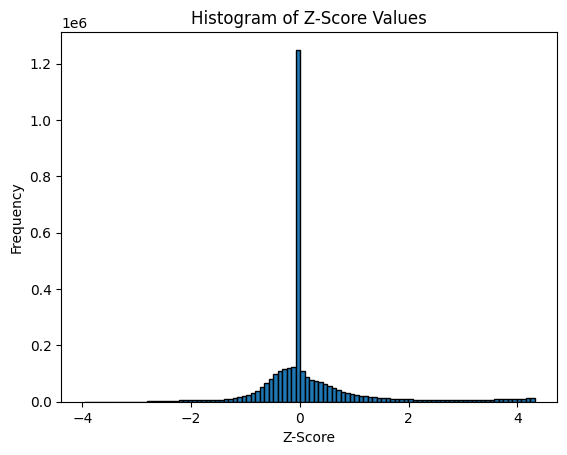

In [14]:
# Drop NaN values from the test_statistic column for plotting
z_score_values = df['z_score'].dropna()

# Create a histogram of the test_statistic values
plt.hist(z_score_values, bins=100, edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Histogram of Z-Score Values')
plt.show()

(array([6.000000e+00, 4.000000e+00, 9.000000e+00, 2.600000e+01,
        4.000000e+01, 4.300000e+01, 6.500000e+01, 7.700000e+01,
        1.260000e+02, 1.620000e+02, 2.400000e+02, 3.400000e+02,
        4.930000e+02, 7.130000e+02, 1.009000e+03, 1.285000e+03,
        1.773000e+03, 2.264000e+03, 2.857000e+03, 3.667000e+03,
        4.178000e+03, 4.749000e+03, 5.046000e+03, 5.159000e+03,
        5.434000e+03, 5.458000e+03, 5.714000e+03, 5.865000e+03,
        6.166000e+03, 6.619000e+03, 7.429000e+03, 8.604000e+03,
        1.053300e+04, 1.296300e+04, 1.511400e+04, 1.916500e+04,
        2.368800e+04, 3.094900e+04, 3.958100e+04, 5.099000e+04,
        6.568500e+04, 8.124300e+04, 9.662400e+04, 1.090730e+05,
        1.168520e+05, 1.202640e+05, 1.227800e+05, 1.249393e+06,
        1.097830e+05, 8.925800e+04, 7.708600e+04, 7.242900e+04,
        6.924300e+04, 6.448000e+04, 5.671800e+04, 4.931800e+04,
        4.107100e+04, 3.417300e+04, 2.957300e+04, 2.645400e+04,
        2.328700e+04, 2.096100e+04, 1.90

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Zoomed in Histogram of Z-score Values')

(-25.0, 25.0)

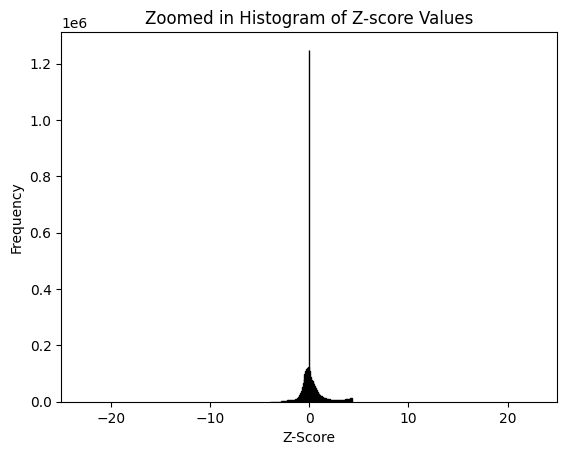

In [15]:
z_score_values = df['z_score'].dropna()
z_score_values = z_score_values[(z_score_values >= -50) & (z_score_values <= 50)]


plt.hist(z_score_values, bins=100, edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Zoomed in Histogram of Z-score Values')
plt.xlim(-25, 25)  # Set x-axis range from -25 to 25
plt.show()

## Summary stats of z-scores

In [16]:
# Drop NaN values from the test_statistic column
z_score_values = df['z_score'].dropna() # NA occurs when the abs diff is 0 and you take log2(0)

# Get summary statistics
summary_stats_z_score = z_score_values.describe()
summary_stats_z_score

count    3.356388e+06
mean     1.866661e-01
std      9.959904e-01
min     -3.972616e+00
25%     -1.852195e-01
50%      0.000000e+00
75%      2.459687e-01
max      4.318894e+00
Name: z_score, dtype: float64

In [17]:
# Get the row with the max test_statistic
max_z_score_row = df.loc[df['z_score'].idxmax()]

# Get the row with the min test_statistic
min_z_score_row = df.loc[df['z_score'].idxmin()]

max_min_z_score_df = pd.DataFrame([max_z_score_row, min_z_score_row])

# Set display options to show all columns
pd.set_option('display.max_columns', None)

max_min_z_score_df

# Reset to default after displaying
pd.reset_option('display.max_columns')

,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,Max_P_Value_Hyp2_above_median,Max_P_Value_Hyp3_below_median,Max_P_Value_Hyp3_above_median,cyclo_total_sum,noncyclo_total_sum,CycloFraction,NoncycloFraction,Cyclo_TPM,Noncyclo_TPM,NormalizedCycloFraction,NormalizedNoncycloFraction,NormalizedFractionDifference,Avg_Cyclo_TPM,Avg_Noncyclo_TPM,gene_cyclo_total,gene_noncyclo_total,isoform_cyclo_proportion,isoform_noncyclo_proportion,SD_Cyclo_TPM,SD_Noncyclo_TPM,Cyclo_Z_Score,Noncyclo_Z_Score,MedianCyclo_TPM,MedianNoncyclo_TPM,Cyclo_TPM_Rank,Noncyclo_TPM_Rank,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,test_statistic,z_score
1936166,PB.26167.542,UDN318336,3,12,incomplete-splice_match,INPP1,ENST00000392329.7,3prime_fragment,1.747844e-01,NaN,0.830556,NaN,1.0,23180599,34005649,1.294186e-07,3.528825e-07,0.129419,0.352883,0.268336,0.731664,-0.463329,0.089102,0.091290,1395,1100,0.002151,0.010909,0.233451,0.104485,0.172700,2.503647,0.00000,0.066015,14.0,18.0,chr2,190343589.0,190371665.0,2q32,2q32.2,147263.0,INPP1,Inositol polyphosphate-1-phosphatase,3628.0,ENSG00000151689,NaN,NaN,Inpp1 (MGI:104848),False,0.717211,4.318894
1165190,PB.151051.625,UDN318336,2863,1586,full-splice_match,DDX5,ENST00000225792.10,alternative_3end,1.947302e-229,0.0,NaN,0.0,NaN,23180599,34005649,1.235085e-04,4.663931e-05,123.508456,46.639310,0.725889,0.274111,0.451779,1483.815013,722.314346,42456,22553,0.067435,0.070323,643.200981,226.310637,-2.114901,-2.985609,1451.31011,739.027523,1.0,1.0,chr17,64498254.0,64506866.0,17q23-q25,17q23.3,180630.0,"""DDX5, HLR1, G17P1""",DEAD-box helicase 5,1655.0,ENSG00000108654,near BRCA1,NaN,Ddx5 (MGI:105037),False,-47.514065,-3.972616


## Write outputs

In [18]:
df.to_csv('test_statistic_hyp3GOE.csv', index=False)

In [19]:
import pickle

# Function to save variables
def save_variables(filename, variables):
    with open(filename, 'wb') as f:
        pickle.dump(variables, f)

# Save specific variables
variables_to_save = {
    'df': df
}
save_variables('Test_statistic_hyp3GOE_notebook_variables.pkl', variables_to_save)

# Load variables from a file
# def load_variables(filename):
#     with open(filename, 'rb') as f:
#         variables = pickle.load(f)
#     return variables

# # Load the variables
# loaded_variables = load_variables('Test_statistic_hyp2GOE_notebook_dont_scale_0_ratio_variables.pkl')

# # Access the loaded variables
# df = loaded_variables['df']

## Positive controls

In [20]:
# LEFT OFF HERE. Display all the positive control cases.

#UDN212054 HARS1
#UDN633333 MFN2
#UDN212054 SET

# Define the pairs to match
matching_pairs = {
    'UDN212054': 'HARS1',
    'UDN633333': 'MFN2',
    'UDN212054': 'HARS1',
    'UDN687128': 'VTA1'
}

# Filter the DataFrame based on the matching pairs
filtered_df = df[df.apply(lambda row: matching_pairs.get(row['Sample']) == row['associated_gene'], axis=1)]

# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#data_df[data_df['associated_gene'] == 'MFN2']
filtered_df

# Reset to default after displaying
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')



,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,Max_P_Value_Hyp2_above_median,Max_P_Value_Hyp3_below_median,Max_P_Value_Hyp3_above_median,cyclo_total_sum,noncyclo_total_sum,CycloFraction,NoncycloFraction,Cyclo_TPM,Noncyclo_TPM,NormalizedCycloFraction,NormalizedNoncycloFraction,NormalizedFractionDifference,Avg_Cyclo_TPM,Avg_Noncyclo_TPM,gene_cyclo_total,gene_noncyclo_total,isoform_cyclo_proportion,isoform_noncyclo_proportion,SD_Cyclo_TPM,SD_Noncyclo_TPM,Cyclo_Z_Score,Noncyclo_Z_Score,MedianCyclo_TPM,MedianNoncyclo_TPM,Cyclo_TPM_Rank,Noncyclo_TPM_Rank,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,test_statistic,z_score
2564544,PB.60131.268,UDN212054,69,69,full-splice_match,HARS1,ENST00000504156.7,alternative_3end,9.495298e-01,1.248468e-27,NaN,7.110173e-39,NaN,5582703,5443396,1.235960e-05,1.267591e-05,12.359604,12.675910,0.493683,0.506317,-0.012634,79.036021,95.673255,160,85,0.431250,0.811765,23.092405,30.740676,-2.887374,-2.699919,78.261022,94.110967,1.0,1.0,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,-21.089183,-3.255374
2564562,PB.60131.271,UDN212054,0,0,full-splice_match,HARS1,ENST00000504156.7,alternative_3end5end,NaN,NaN,NaN,NaN,NaN,5582703,5443396,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.172083,0.324832,160,85,0.000000,0.000000,0.272517,0.497972,-0.631457,-0.652310,0.000000,0.062150,6.0,5.0,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,-1.484181,0.000000
2564580,PB.60131.272,UDN212054,1,1,full-splice_match,HARS1,ENST00000438307.6,alternative_3end,1.000000e+00,1.433702e-01,NaN,7.408294e-01,NaN,5582703,5443396,1.791247e-07,1.837088e-07,0.179125,0.183709,0.493683,0.506317,-0.012634,1.561667,1.923229,160,85,0.006250,0.011765,0.848478,1.008062,-1.629438,-1.725608,1.365318,1.604220,1.0,1.0,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,-3.382251,-0.062751
2564598,PB.60131.273,UDN212054,0,0,incomplete-splice_match,HARS1,ENST00000504366.5,3prime_fragment,NaN,NaN,NaN,NaN,NaN,5582703,5443396,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.391329,0.408552,160,85,0.000000,0.000000,0.289952,0.389146,-1.349634,-1.049870,0.381769,0.418611,2.5,3.5,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,-1.145309,0.000000
2564616,PB.60131.274,UDN212054,0,1,incomplete-splice_match,HARS1,ENST00000675898.1,3prime_fragment,9.899188e-01,NaN,1.000000e+00,NaN,NaN,5582703,5443396,0.000000e+00,1.837088e-07,0.000000,0.183709,0.000000,1.000000,-1.000000,0.251560,0.347369,160,85,0.000000,0.011765,0.364461,0.483495,-0.690224,-0.338494,0.062629,0.137070,5.0,11.0,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,-1.737666,-0.674563
2564634,PB.60131.275,UDN212054,0,0,incomplete-splice_match,HARS1,ENST00000675898.1,3prime_fragment,NaN,NaN,NaN,NaN,NaN,5582703,5443396,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.308375,0.226338,160,85,0.000000,0.000000,0.397525,0.220309,-0.775737,-1.027363,0.194235,0.

## SRSF6 cassette exon positive control

In [21]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

df[df['associated_gene'] == 'SRSF6']

# Reset to default after displaying
pd.reset_option('display.max_columns')


,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,Max_P_Value_Hyp2_above_median,Max_P_Value_Hyp3_below_median,Max_P_Value_Hyp3_above_median,cyclo_total_sum,noncyclo_total_sum,CycloFraction,NoncycloFraction,Cyclo_TPM,Noncyclo_TPM,NormalizedCycloFraction,NormalizedNoncycloFraction,NormalizedFractionDifference,Avg_Cyclo_TPM,Avg_Noncyclo_TPM,gene_cyclo_total,gene_noncyclo_total,isoform_cyclo_proportion,isoform_noncyclo_proportion,SD_Cyclo_TPM,SD_Noncyclo_TPM,Cyclo_Z_Score,Noncyclo_Z_Score,MedianCyclo_TPM,MedianNoncyclo_TPM,Cyclo_TPM_Rank,Noncyclo_TPM_Rank,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,test_statistic,z_score
1494972,PB.164087.115,BCH_1877-01,11,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,0.002781,NaN,NaN,NaN,1.000000,8514101,8390417,1.291974e-06,0.000000e+00,1.291974,0.000000,1.000000,0.000000,1.000000,0.285913,0.02281,1297,685,0.008481,0.000000,0.457893,0.062997,2.197154,-0.362082,0.000000,0.0,17.0,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,-0.300218,0.000000
1494973,PB.164087.115,BCH_2410-01,0,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,NaN,NaN,NaN,NaN,NaN,5115261,5604045,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.285913,0.02281,106,96,0.000000,0.000000,0.457893,0.062997,-0.624411,-0.362082,0.000000,0.0,5.5,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,-0.300218,0.000000
1494974,PB.164087.115,BCH_2275-01,2,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,0.410155,NaN,NaN,NaN,1.000000,5298875,6226665,3.774386e-07,0.000000e+00,0.377439,0.000000,1.000000,0.000000,1.000000,0.285913,0.02281,417,307,0.004796,0.000000,0.457893,0.062997,0.199884,-0.362082,0.000000,0.0,14.0,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,-0.300218,0.000000
1494975,PB.164087.115,BCH_2443-01,0,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,NaN,NaN,NaN,NaN,NaN,7983565,8045116,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.285913,0.02281,60,40,0.000000,0.000000,0.457893,0.062997,-0.624411,-0.362082,0.000000,0.0,5.5,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,-0.300218,0.000000
1494976,PB.164087.115,BCH_0252-01,2,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,0.671662,NaN,NaN,NaN,1.000000,6655551,4374934,3.005010e-07,0.000000e+00,0.300501,0.000000,1.000000,0.000000,1.000000,0.285913,0.02281,402,308,0.004975,0.000000,0.457893,0.062997,0.031858,-0.362082,0.000000,0.0,13.0,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,-0.300218,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495435,PB.164087.72,UDN215640,5,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,0.060249,NaN,NaN,NaN,0.938792,5138817,5563025,9.729866e-07,0.000000e+00,0.972987,0.000000,1.000000,0.000000,1.000000,3.596065,0.07792,417,193,0.011990,0.000000,6.381554,0.169003,-0.411041,

## Histogram of Z-score in a single patient

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 5.0000e+00, 4.0000e+00, 1.1000e+01, 7.0000e+00,
        1.6000e+01, 1.8000e+01, 2.7000e+01, 3.9000e+01, 4.6000e+01,
        6.5000e+01, 9.4000e+01, 1.1400e+02, 1.6400e+02, 2.1500e+02,
        2.7700e+02, 4.1400e+02, 5.6100e+02, 7.1400e+02, 9.1900e+02,
        1.1730e+03, 1.4970e+03, 1.9350e+03, 2.4930e+03, 3.1860e+03,
        4.2240e+03, 5.2320e+03, 6.8550e+03, 7.7200e+03, 8.7430e+03,
        8.5420e+03, 7.7950e+03, 6.4720e+03, 5.4030e+03, 4.6450e+03,
        4.5540e+03, 6.3909e+04, 2.8850e+03, 2.8540e+03, 2.7160e+03,
        2.5660e+03, 2.5010e+03, 2.3660e+03, 2.0900e+03, 1.8400e+03,
        1.6880e+03, 1.4410e+03, 1.2540e+03, 1.0530e+03, 9.3100e+02,
        8.2800e+02, 7.8100e+02, 7.1300e+02, 5.6700e+02, 5.3300e+02,
        5.1100e+02, 4.7400e+02, 4.3300e+02, 4.3200e+02, 3.3800e+02,
        3.1900e+02, 2.9300e+02, 2.7000e+02, 2.7400e+02, 2.3700e+02,
        1.8200e+02, 1.9000e+02, 1.8200e+02, 2.14

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_1877-01')

(array([2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 5.0000e+00, 1.0000e+00,
        6.0000e+00, 2.0000e+00, 9.0000e+00, 1.3000e+01, 5.0000e+00,
        1.1000e+01, 2.3000e+01, 3.4000e+01, 2.7000e+01, 3.2000e+01,
        5.7000e+01, 6.4000e+01, 7.7000e+01, 1.3100e+02, 1.7000e+02,
        2.0600e+02, 2.6900e+02, 3.5800e+02, 4.8500e+02, 6.0300e+02,
        8.2500e+02, 1.0680e+03, 1.4470e+03, 1.8500e+03, 2.3730e+03,
        3.2070e+03, 3.9980e+03, 4.7590e+03, 5.6600e+03, 6.8720e+03,
        8.0350e+03, 8.1840e+03, 7.6412e+04, 5.4660e+03, 4.3430e+03,
        4.5260e+03, 4.2090e+03, 3.8570e+03, 3.8730e+03, 3.5160e+03,
        3.1410e+03, 2.6690e+03, 2.2070e+03, 1.9390e+03, 1.5870e+03,
        1.3670e+03, 1.2040e+03, 1.0360e+03, 9.3400e+02, 8.8500e+02,
        7.1800e+02, 6.6700e+02, 6.0800e+02, 5.6500e+02, 5.7100e+02,
        5.3200e+02, 4.8100e+02, 4.2300e+02, 4.0100e+02, 4.0500e+02,
        3.4000e+02, 3.1400e+02, 2.7600e+02, 2.92

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_2410-01')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 6.0000e+00, 2.0000e+00,
        1.0000e+00, 7.0000e+00, 7.0000e+00, 1.1000e+01, 1.2000e+01,
        2.1000e+01, 2.7000e+01, 3.9000e+01, 5.4000e+01, 8.3000e+01,
        1.0200e+02, 1.1400e+02, 1.6300e+02, 2.4700e+02, 2.9600e+02,
        3.8000e+02, 5.4500e+02, 5.9200e+02, 8.0700e+02, 1.0420e+03,
        1.2760e+03, 1.7540e+03, 2.2330e+03, 2.7370e+03, 3.5260e+03,
        4.4430e+03, 5.3030e+03, 6.3840e+03, 7.6270e+03, 8.4810e+03,
        8.1330e+03, 6.8590e+03, 7.1802e+04, 4.7560e+03, 4.5340e+03,
        3.6680e+03, 3.6330e+03, 3.6430e+03, 3.4320e+03, 3.0530e+03,
        2.5660e+03, 2.1540e+03, 1.8580e+03, 1.5300e+03, 1.3440e+03,
        1.1220e+03, 9.0400e+02, 8.7600e+02, 7.3700e+02, 6.9400e+02,
        6.5400e+02, 5.6300e+02, 5.8500e+02, 5.2800e+02, 4.5200e+02,
        3.7400e+02, 3.7000e+02, 3.7900e+02, 3.0500e+02, 2.8800e+02,
        2.7400e+02, 2.7000e+02, 2.8400e+02, 2.28

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_2275-01')

(array([1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 5.0000e+00, 7.0000e+00,
        7.0000e+00, 5.0000e+00, 1.4000e+01, 1.7000e+01, 2.0000e+01,
        2.3000e+01, 4.1000e+01, 5.5000e+01, 9.3000e+01, 1.4400e+02,
        1.8000e+02, 2.2900e+02, 3.0900e+02, 4.1500e+02, 5.5700e+02,
        7.6300e+02, 9.4700e+02, 1.1300e+03, 1.3810e+03, 1.8020e+03,
        2.2510e+03, 2.8700e+03, 3.8230e+03, 4.7140e+03, 6.0890e+03,
        7.0520e+03, 7.9520e+03, 8.1520e+03, 7.1510e+03, 6.1130e+03,
        5.0480e+03, 4.4840e+03, 3.7030e+03, 6.6578e+04, 3.2390e+03,
        2.7990e+03, 2.7070e+03, 2.7480e+03, 2.5380e+03, 2.4690e+03,
        2.0900e+03, 1.9060e+03, 1.6520e+03, 1.4900e+03, 1.4440e+03,
        1.1660e+03, 1.0720e+03, 9.7400e+02, 9.1300e+02, 7.8200e+02,
        7.0800e+02, 7.1400e+02, 6.3200e+02, 5.9300e+02, 5.2300e+02,
        4.8100e+02, 4.6700e+02, 4.5900e+02, 3.9300e+02, 3.3900e+02,
        3.1000e+02, 2.8600e+02, 2.7400e+02, 2.35

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_2443-01')

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00,
        4.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 9.0000e+00,
        2.0000e+01, 2.5000e+01, 3.6000e+01, 3.6000e+01, 5.8000e+01,
        6.5000e+01, 8.8000e+01, 1.0400e+02, 1.4400e+02, 1.7100e+02,
        2.5300e+02, 2.9000e+02, 3.7500e+02, 4.4900e+02, 5.6900e+02,
        7.0700e+02, 9.5200e+02, 1.2090e+03, 1.5920e+03, 2.0480e+03,
        2.4330e+03, 3.1540e+03, 3.5160e+03, 3.7400e+03, 4.3700e+03,
        4.9710e+03, 7.5278e+04, 8.6360e+03, 6.9510e+03, 5.4130e+03,
        4.8820e+03, 4.6950e+03, 4.3670e+03, 3.7120e+03, 3.3170e+03,
        2.9450e+03, 2.6060e+03, 2.1860e+03, 1.9770e+03, 1.9580e+03,
        1.6580e+03, 1.5450e+03, 1.5200e+03, 1.3850e+03, 1.1670e+03,
        1.1630e+03, 1.0370e+03, 9.2200e+02, 9.2900e+02, 7.1900e+02,
        6.4500e+02, 6.4400e+02, 6.0900e+02, 5.2700e+02, 4.7900e+02,
        4.7700e+02, 4.3000e+02, 4.1200e+02, 3.83

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_0252-01')

(array([2.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00, 3.0000e+00,
        2.0000e+00, 5.0000e+00, 6.0000e+00, 7.0000e+00, 1.4000e+01,
        1.0000e+01, 1.9000e+01, 2.1000e+01, 3.7000e+01, 3.1000e+01,
        3.2000e+01, 5.5000e+01, 5.7000e+01, 5.9000e+01, 6.8000e+01,
        8.9000e+01, 1.0600e+02, 1.0600e+02, 1.1600e+02, 1.3500e+02,
        1.4200e+02, 1.8500e+02, 2.0800e+02, 2.1800e+02, 2.4400e+02,
        3.0300e+02, 3.4700e+02, 3.9100e+02, 5.4500e+02, 6.1900e+02,
        7.9700e+02, 9.4400e+02, 1.2470e+03, 1.4890e+03, 1.9190e+03,
        2.3850e+03, 2.8500e+03, 3.4570e+03, 3.7650e+03, 4.2820e+03,
        4.8110e+03, 7.6683e+04, 7.3570e+03, 5.3240e+03, 4.6240e+03,
        4.4460e+03, 4.2740e+03, 3.7640e+03, 3.4020e+03, 2.6610e+03,
        2.3160e+03, 1.9250e+03, 1.6870e+03, 1.6180e+03, 1.3990e+03,
        1.3290e+03, 1.2820e+03, 1.0710e+03, 1.0230e+03, 9.3100e+02,
        8.3800e+02, 9.6000e+02, 7.8000e+02, 7.1200e+02, 7.1700e+02,
        6.8100e+02, 6.1300e+02, 6.4600e+02, 5.92

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_1199-01')

(array([1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00, 5.0000e+00,
        7.0000e+00, 1.6000e+01, 1.4000e+01, 1.5000e+01, 3.0000e+01,
        2.4000e+01, 4.9000e+01, 6.0000e+01, 6.6000e+01, 7.7000e+01,
        1.0200e+02, 1.4700e+02, 1.8400e+02, 2.3500e+02, 2.6400e+02,
        3.7500e+02, 4.8400e+02, 6.4100e+02, 7.3800e+02, 9.0600e+02,
        1.1540e+03, 1.4610e+03, 1.8370e+03, 2.3380e+03, 2.9910e+03,
        3.7540e+03, 4.4020e+03, 5.2630e+03, 6.0510e+03, 6.8810e+03,
        7.6450e+03, 7.2560e+03, 7.1273e+04, 3.9690e+03, 4.0030e+03,
        4.0180e+03, 3.7520e+03, 3.5550e+03, 3.2730e+03, 2.8740e+03,
        2.5100e+03, 2.0570e+03, 1.8380e+03, 1.5750e+03, 1.4350e+03,
        1.4490e+03, 1.2670e+03, 1.1190e+03, 1.0260e+03, 9.7800e+02,
        8.4900e+02, 8.6700e+02, 8.2200e+02, 7.0100e+02, 7.2300e+02,
        6.8800e+02, 7.0600e+02, 5.9000e+02, 5.3300e+02, 5.1100e+02,
        4.5300e+02, 4.2400e+02, 4.2200e+02, 4.00

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_1986-01')

(array([2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        1.000e+00, 6.000e+00, 1.000e+01, 5.000e+00, 1.100e+01, 1.700e+01,
        1.900e+01, 3.300e+01, 4.400e+01, 6.500e+01, 6.400e+01, 9.700e+01,
        1.410e+02, 1.570e+02, 2.870e+02, 2.930e+02, 3.820e+02, 5.240e+02,
        6.070e+02, 7.470e+02, 9.810e+02, 1.188e+03, 1.574e+03, 1.998e+03,
        2.492e+03, 3.166e+03, 3.787e+03, 4.481e+03, 5.530e+03, 6.284e+03,
        7.126e+03, 7.342e+03, 6.498e+03, 5.423e+03, 7.028e+04, 4.441e+03,
        3.665e+03, 3.335e+03, 3.272e+03, 3.300e+03, 3.123e+03, 2.813e+03,
        2.357e+03, 2.150e+03, 1.954e+03, 1.642e+03, 1.507e+03, 1.324e+03,
        1.256e+03, 1.132e+03, 1.034e+03, 1.003e+03, 9.020e+02, 9.660e+02,
        8.430e+02, 8.520e+02, 6.890e+02, 6.040e+02, 5.990e+02, 5.750e+02,
        4.930e+02, 4.730e+02, 4.130e+02, 4.120e+02, 3.760e+02, 3.380e+02,
        3.750e+02, 3.070e+02, 2.860e+02, 2.540e+02, 2.640e+02, 2.630e+02,
        2.550e+02, 2.390e+02, 2.390e+0

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_310-01')

(array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 1.400e+01,
        1.100e+01, 2.000e+01, 2.600e+01, 2.600e+01, 4.600e+01, 4.400e+01,
        9.600e+01, 1.190e+02, 1.480e+02, 2.050e+02, 2.560e+02, 3.870e+02,
        4.540e+02, 5.960e+02, 7.920e+02, 1.088e+03, 1.433e+03, 1.837e+03,
        2.276e+03, 2.780e+03, 3.393e+03, 4.090e+03, 4.476e+03, 5.448e+03,
        7.038e+03, 7.257e+04, 8.657e+03, 6.886e+03, 5.313e+03, 5.024e+03,
        4.368e+03, 3.987e+03, 3.755e+03, 3.470e+03, 3.160e+03, 2.612e+03,
        2.220e+03, 1.881e+03, 1.803e+03, 1.660e+03, 1.475e+03, 1.286e+03,
        1.091e+03, 1.140e+03, 9.700e+02, 8.460e+02, 7.500e+02, 7.670e+02,
        6.970e+02, 5.890e+02, 5.720e+02, 5.370e+02, 4.580e+02, 4.350e+02,
        3.830e+02, 3.650e+02, 3.890e+02, 3.870e+02, 3.620e+02, 3.020e+02,
        2.840e+02, 2.890e+02, 2.960e+02, 2.490e+02, 2.760e+02, 2.750e+02,
        2.550e+02, 2.380e+02, 2.440e+0

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_2401-01')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        3.0000e+00, 3.0000e+00, 4.0000e+00, 7.0000e+00, 1.0000e+01,
        1.3000e+01, 2.0000e+01, 2.7000e+01, 4.7000e+01, 7.1000e+01,
        9.4000e+01, 1.2300e+02, 1.9300e+02, 2.1800e+02, 2.9300e+02,
        4.1700e+02, 5.8400e+02, 7.8600e+02, 1.0630e+03, 1.4650e+03,
        2.0150e+03, 2.5160e+03, 3.2960e+03, 4.1850e+03, 4.9580e+03,
        5.8260e+03, 6.9680e+03, 8.5780e+03, 8.9280e+03, 7.4255e+04,
        6.7850e+03, 4.7440e+03, 4.2970e+03, 4.3360e+03, 4.3460e+03,
        3.7540e+03, 3.3380e+03, 2.8200e+03, 2.4300e+03, 1.8900e+03,
        1.6600e+03, 1.4620e+03, 1.2260e+03, 1.1290e+03, 9.0900e+02,
        9.0300e+02, 7.7600e+02, 6.5800e+02, 6.8200e+02, 5.4900e+02,
        5.5300e+02, 5.1200e+02, 4.7900e+02, 5.0700e+02, 4.7200e+02,
        4.5300e+02, 3.1900e+02, 3.4300e+02, 3.15

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN052264')

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+00, 7.0000e+00, 9.0000e+00, 1.6000e+01,
        2.9000e+01, 2.4000e+01, 3.5000e+01, 4.5000e+01, 7.6000e+01,
        1.0300e+02, 1.2100e+02, 1.7200e+02, 2.0800e+02, 2.9200e+02,
        3.2900e+02, 4.4700e+02, 5.5500e+02, 7.6300e+02, 9.3500e+02,
        1.1950e+03, 1.4720e+03, 1.7490e+03, 2.1640e+03, 2.8730e+03,
        3.7960e+03, 4.5760e+03, 5.7920e+03, 6.8850e+03, 7.9950e+03,
        8.1410e+03, 7.4560e+03, 5.7380e+03, 5.3270e+03, 4.7380e+03,
        6.3434e+04, 3.2490e+03, 3.3890e+03, 2.9440e+03, 2.9140e+03,
        2.7850e+03, 2.6170e+03, 2.2870e+03, 2.0880e+03, 1.7610e+03,
        1.5470e+03, 1.3800e+03, 1.2670e+03, 1.0650e+03, 9.6200e+02,
        9.0200e+02, 8.4700e+02, 7.4300e+02, 7.0200e+02, 6.2300e+02,
        6.1500e+02, 6.8400e+02, 5.5600e+02, 5.0200e+02, 4.8500e+02,
        4.4100e+02, 4.4100e+02, 4.6700e+02, 4.98

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN121217')

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 6.000e+00, 7.000e+00, 1.300e+01,
        1.200e+01, 1.700e+01, 1.900e+01, 3.200e+01, 4.600e+01, 5.600e+01,
        8.100e+01, 1.220e+02, 1.550e+02, 1.980e+02, 2.630e+02, 3.400e+02,
        3.830e+02, 5.550e+02, 7.100e+02, 9.540e+02, 1.096e+03, 1.400e+03,
        1.808e+03, 2.349e+03, 2.931e+03, 3.749e+03, 4.610e+03, 5.649e+03,
        6.704e+03, 7.695e+03, 7.869e+03, 7.245e+03, 6.105e+03, 5.394e+03,
        6.431e+04, 3.925e+03, 3.563e+03, 2.950e+03, 2.895e+03, 2.833e+03,
        2.898e+03, 2.730e+03, 2.225e+03, 1.860e+03, 1.720e+03, 1.434e+03,
        1.346e+03, 1.148e+03, 1.056e+03, 1.086e+03, 9.650e+02, 8.640e+02,
        8.020e+02, 7.470e+02, 7.820e+02, 6.670e+02, 6.460e+02, 6.420e+02,
        5.660e+02, 5.240e+02, 5.520e+02, 5.110e+02, 4.580e+02, 4.160e+02,
        3.850e+02, 3.730e+02, 3.480e+02, 3.640e+02, 3.360e+02, 3.260e+02,
        3.350e+02, 3.030e+02, 3.160e+0

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN178694')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        2.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 4.0000e+00,
        4.0000e+00, 8.0000e+00, 1.4000e+01, 1.2000e+01, 3.2000e+01,
        3.2000e+01, 5.1000e+01, 6.8000e+01, 9.4000e+01, 1.1800e+02,
        1.4100e+02, 2.2100e+02, 2.8000e+02, 4.2100e+02, 6.0200e+02,
        6.9800e+02, 9.2700e+02, 1.1620e+03, 1.6210e+03, 2.1060e+03,
        2.5140e+03, 3.3190e+03, 4.1250e+03, 4.8590e+03, 5.7450e+03,
        6.9960e+03, 7.9040e+03, 8.1270e+03, 7.6368e+04, 5.4650e+03,
        4.1640e+03, 4.2280e+03, 4.1040e+03, 3.9900e+03, 3.5190e+03,
        3.2010e+03, 2.7790e+03, 2.3330e+03, 1.8500e+03, 1.6250e+03,
        1.4100e+03, 1.2200e+03, 1.1750e+03, 1.0580e+03, 8.7300e+02,
        8.2600e+02, 7.3300e+02, 7.1100e+02, 5.4200e+02, 6.0000e+02,
        5.4700e+02, 5.0600e+02, 4.9500e+02, 4.9800e+02, 4.2200e+02,
        3.7800e+02, 3.4600e+02, 3.5300e+02, 3.32

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN212054')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 4.0000e+00, 4.0000e+00, 1.0000e+01, 1.7000e+01,
        1.7000e+01, 1.9000e+01, 4.2000e+01, 5.2000e+01, 8.7000e+01,
        1.0000e+02, 1.2900e+02, 1.7200e+02, 2.6500e+02, 3.5500e+02,
        4.6400e+02, 5.9600e+02, 7.5100e+02, 1.0720e+03, 1.3650e+03,
        1.8170e+03, 2.3740e+03, 3.0010e+03, 3.9210e+03, 4.8130e+03,
        5.5620e+03, 6.5410e+03, 8.0140e+03, 8.5520e+03, 7.7721e+04,
        6.4010e+03, 4.3010e+03, 4.3600e+03, 4.3760e+03, 4.0770e+03,
        3.7060e+03, 3.4620e+03, 3.0470e+03, 2.4770e+03, 2.0060e+03,
        1.6950e+03, 1.4100e+03, 1.2580e+03, 1.1870e+03, 9.8900e+02,
        9.1300e+02, 8.7200e+02, 7.1500e+02, 6.4200e+02, 6.1200e+02,
        5.3300e+02, 5.5600e+02, 5.1100e+02, 4.8200e+02, 4.2500e+02,
        3.7600e+02, 3.6200e+02, 3.5400e+02, 2.94

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN215640')

(array([5.0000e+00, 4.0000e+00, 9.0000e+00, 2.5000e+01, 3.9000e+01,
        4.2000e+01, 6.0000e+01, 7.4000e+01, 1.2000e+02, 1.5400e+02,
        2.3000e+02, 3.2000e+02, 4.7200e+02, 6.9800e+02, 9.7100e+02,
        1.2410e+03, 1.7030e+03, 2.1720e+03, 2.7690e+03, 3.4970e+03,
        3.9700e+03, 4.4720e+03, 4.7190e+03, 4.6970e+03, 4.7830e+03,
        4.5610e+03, 4.4420e+03, 4.3010e+03, 3.9040e+03, 3.6940e+03,
        3.3660e+03, 3.2190e+03, 3.3490e+03, 3.2710e+03, 2.9280e+03,
        3.0250e+03, 2.8980e+03, 2.6660e+03, 2.2550e+03, 1.9520e+03,
        2.0400e+03, 1.8900e+03, 1.6350e+03, 1.5990e+03, 1.4630e+03,
        1.4270e+03, 1.3010e+03, 2.6978e+04, 1.2230e+03, 1.5660e+03,
        1.3100e+03, 1.2470e+03, 1.4820e+03, 1.3490e+03, 1.4210e+03,
        1.5330e+03, 1.4800e+03, 1.1580e+03, 8.7100e+02, 9.1600e+02,
        8.5200e+02, 8.7400e+02, 7.8000e+02, 8.2900e+02, 6.8500e+02,
        6.4800e+02, 5.8700e+02, 5.7000e+02, 5.3300e+02, 6.2800e+02,
        6.1400e+02, 4.9100e+02, 5.5900e+02, 5.51

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN318336')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00,
        5.0000e+00, 1.0000e+01, 8.0000e+00, 9.0000e+00, 3.0000e+01,
        4.3000e+01, 5.1000e+01, 7.3000e+01, 1.0700e+02, 1.4700e+02,
        2.4400e+02, 3.1600e+02, 4.3700e+02, 6.0800e+02, 7.8800e+02,
        1.0460e+03, 1.4280e+03, 1.9880e+03, 2.6220e+03, 3.4330e+03,
        4.5470e+03, 5.6650e+03, 7.2200e+03, 8.6040e+03, 8.6940e+03,
        7.8720e+03, 6.5590e+03, 6.8682e+04, 4.1350e+03, 4.2160e+03,
        3.9450e+03, 3.7270e+03, 3.5890e+03, 3.2840e+03, 2.9720e+03,
        2.6140e+03, 2.1010e+03, 1.7380e+03, 1.6040e+03, 1.4040e+03,
        1.1800e+03, 1.1190e+03, 1.1760e+03, 1.0410e+03, 9.0900e+02,
        9.0400e+02, 7.6400e+02, 7.8300e+02, 6.4800e+02, 6.1000e+02,
        5.6200e+02, 5.2300e+02, 4.8500e+02, 4.00

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN374570')

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        4.0000e+00, 1.0000e+00, 3.0000e+00, 8.0000e+00, 9.0000e+00,
        9.0000e+00, 1.4000e+01, 1.5000e+01, 2.6000e+01, 3.5000e+01,
        4.3000e+01, 6.3000e+01, 8.3000e+01, 1.0800e+02, 1.0800e+02,
        1.7800e+02, 2.3400e+02, 2.7000e+02, 3.9000e+02, 5.1600e+02,
        6.4400e+02, 8.6100e+02, 1.1510e+03, 1.5120e+03, 1.9250e+03,
        2.5360e+03, 3.1050e+03, 3.7730e+03, 4.4280e+03, 5.0560e+03,
        6.6140e+03, 8.0320e+03, 7.1455e+04, 7.0310e+03, 5.5300e+03,
        5.0050e+03, 4.1490e+03, 4.1100e+03, 4.0160e+03, 3.7100e+03,
        3.3840e+03, 2.7200e+03, 2.3180e+03, 2.1550e+03, 1.7460e+03,
        1.6220e+03, 1.4940e+03, 1.4640e+03, 1.0740e+03, 1.1130e+03,
        9.0800e+02, 8.9100e+02, 8.6700e+02, 8.5100e+02, 7.1200e+02,
        6.4900e+02, 5.5500e+02, 5.6400e+02, 5.3300e+02, 5.8300e+02,
        4.8700e+02, 4.7700e+02, 4.4300e+02, 4.09

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN633333')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00,
        7.0000e+00, 6.0000e+00, 1.3000e+01, 1.3000e+01, 2.2000e+01,
        2.8000e+01, 3.8000e+01, 3.4000e+01, 5.5000e+01, 6.4000e+01,
        8.8000e+01, 1.0100e+02, 1.8800e+02, 2.1500e+02, 2.5300e+02,
        3.7300e+02, 4.7100e+02, 5.9000e+02, 6.9200e+02, 9.1800e+02,
        1.1110e+03, 1.4560e+03, 1.9580e+03, 2.5250e+03, 3.2350e+03,
        4.1330e+03, 5.0750e+03, 6.1980e+03, 7.4470e+03, 8.3660e+03,
        8.2980e+03, 7.0600e+03, 6.2510e+03, 6.9773e+04, 3.9410e+03,
        3.8130e+03, 3.5560e+03, 3.2420e+03, 3.1730e+03, 2.9270e+03,
        2.7210e+03, 2.3800e+03, 1.9670e+03, 1.6090e+03, 1.2750e+03,
        1.1380e+03, 1.0100e+03, 9.3000e+02, 8.3800e+02, 8.1400e+02,
        7.1600e+02, 7.3900e+02, 6.1200e+02, 5.9500e+02, 5.1200e+02,
        4.8500e+02, 4.4400e+02, 4.1500e+02, 3.9700e+02, 4.3800e+02,
        3.6700e+02, 3.3600e+02, 3.1200e+02, 2.61

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN687128')

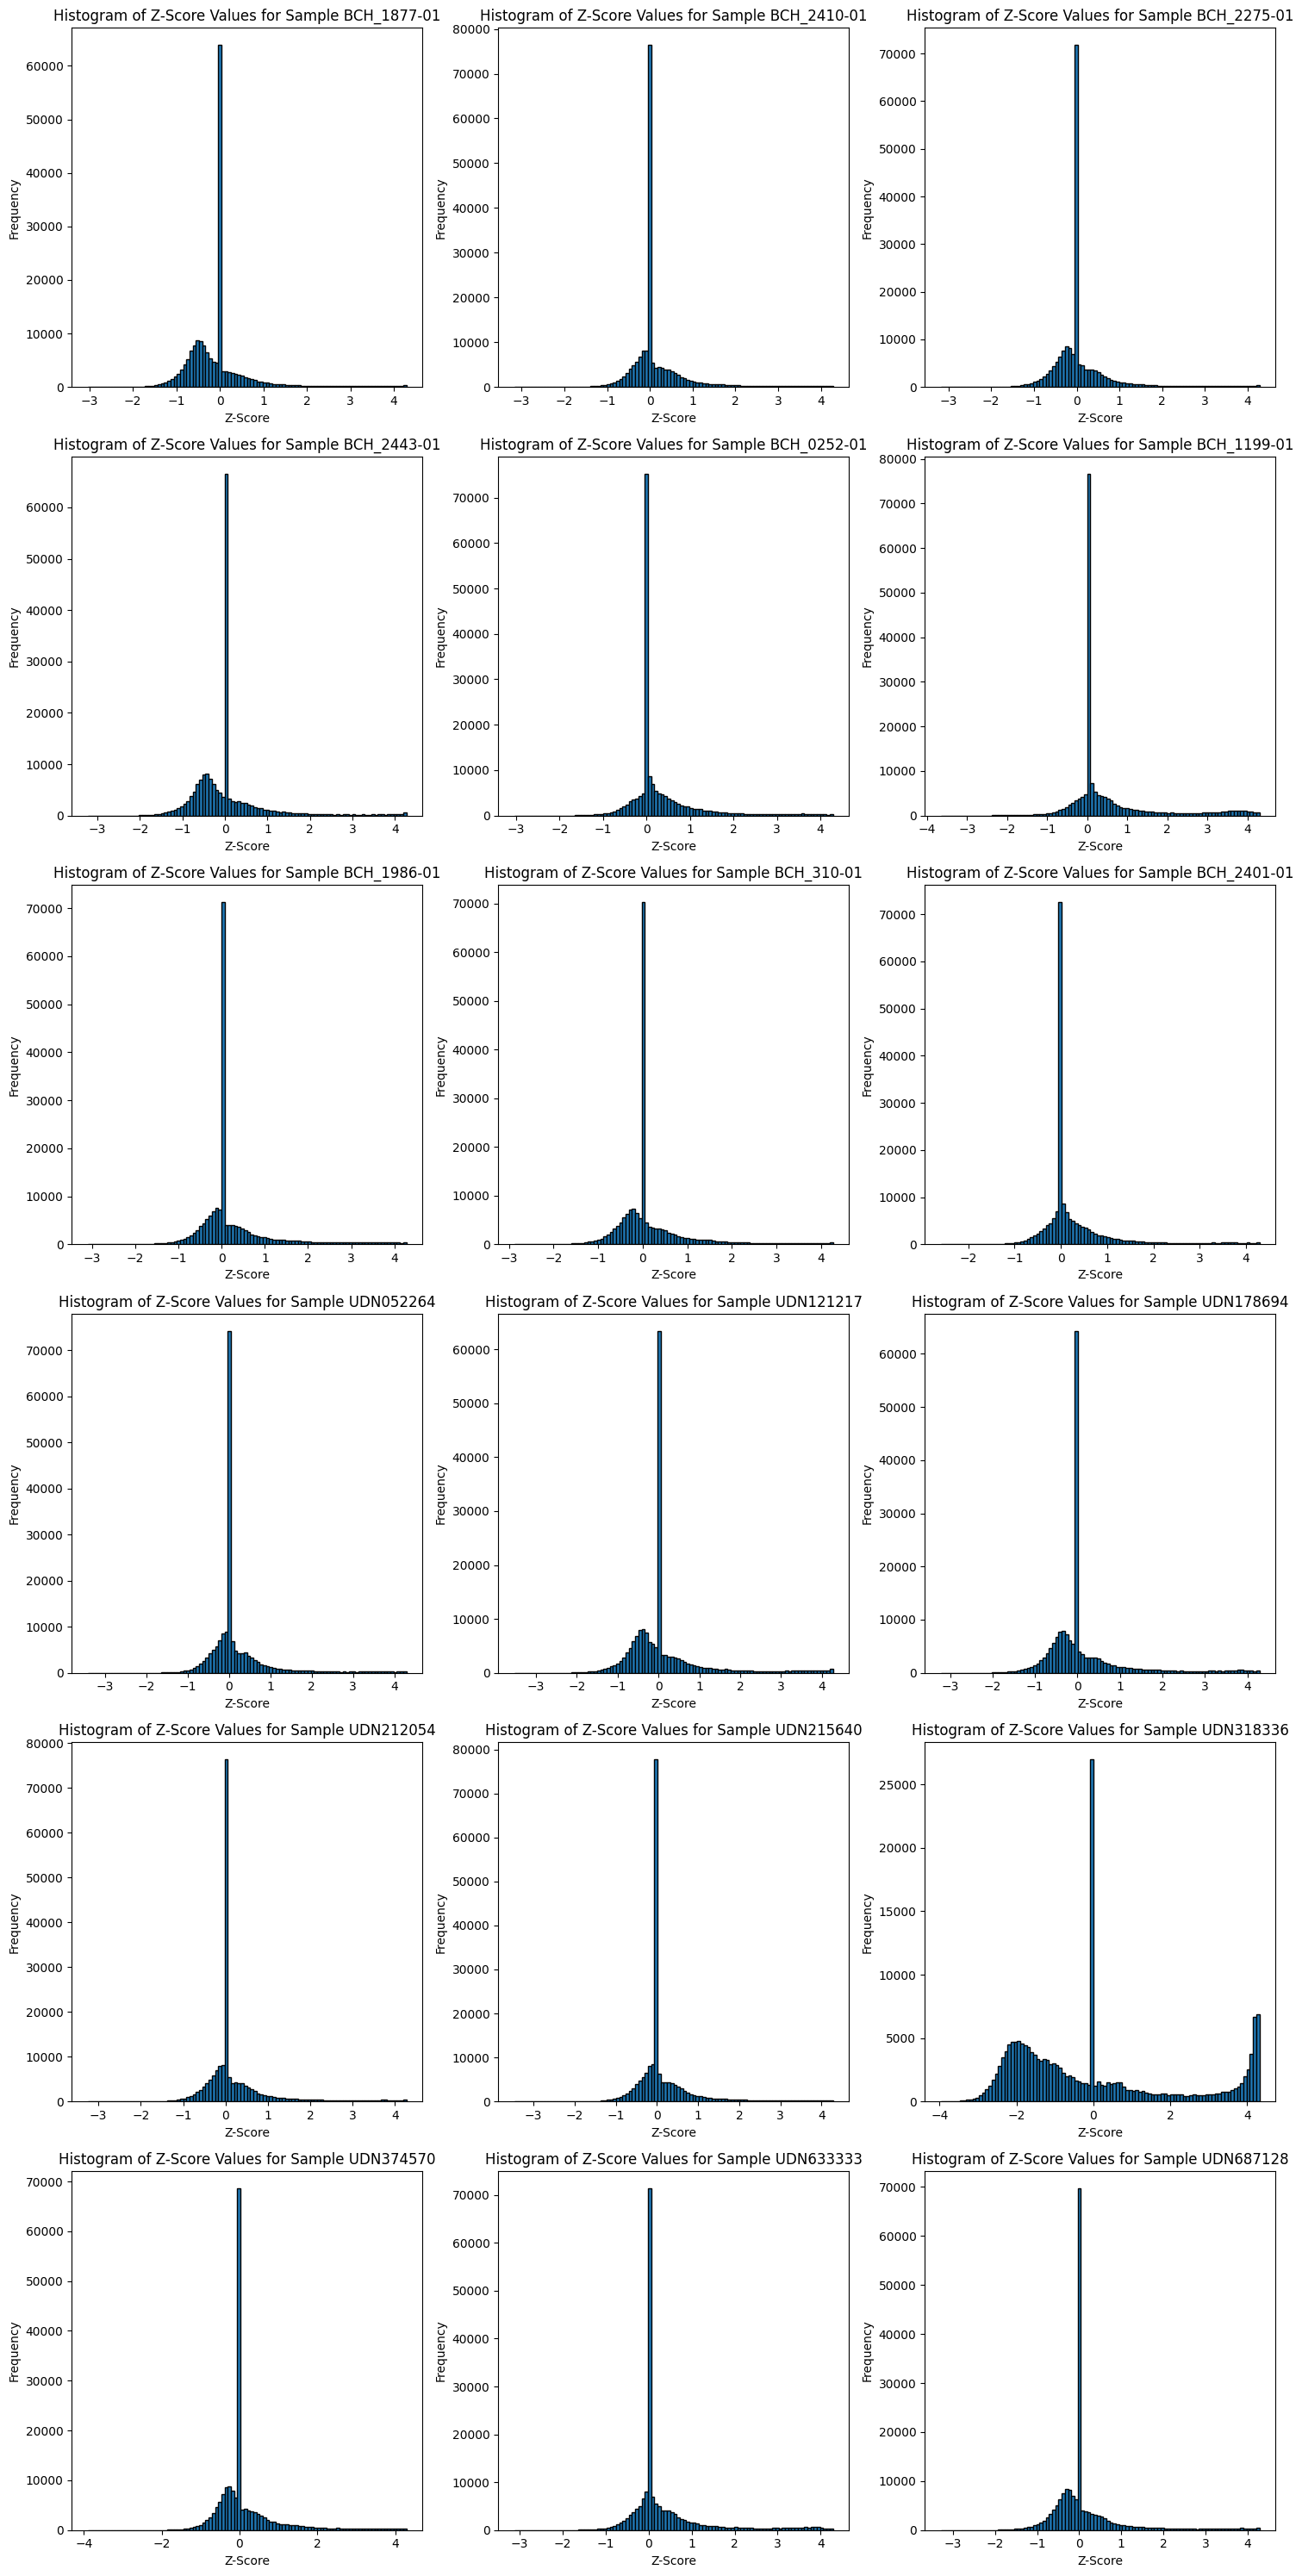

In [22]:
# Get unique samples
unique_samples = df['Sample'].unique()

# Create subplots
num_samples = len(unique_samples)
num_cols = 3
num_rows = (num_samples + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, sample in enumerate(unique_samples):
    filtered_df = df[df['Sample'] == sample]
    z_score_values = filtered_df['z_score'].dropna()
    
    # Create histogram in the appropriate subplot
    axes[i].hist(z_score_values, bins=100, edgecolor='black')
    axes[i].set_xlabel('Z-Score')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of Z-Score Values for Sample {sample}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Test statistic Z-score vs test statistic

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(0.5, 0, 'Test Statistic')

Text(0, 0.5, 'Test Statistic Z-Score')

Text(0.5, 1.0, 'Scatter Plot of Z-Score vs Test Statistic for Sample UDN215640')

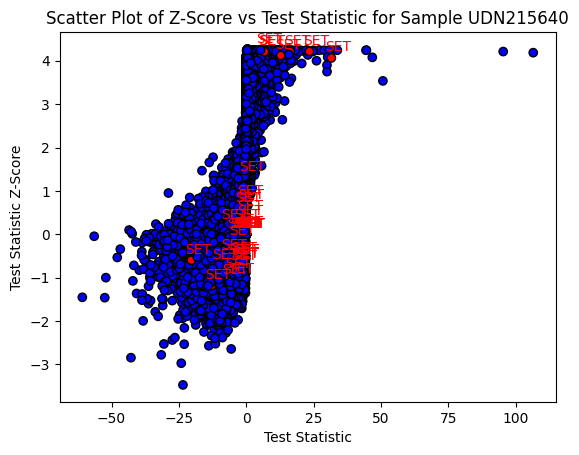

In [23]:
# Filter the DataFrame to include only rows for the sample 'UDN212054'
filtered_df = df[df['Sample'] == 'UDN212054']

# Create a scatter plot with different colors
colors = ['red' if gene == 'HARS1' else 'blue' for gene in filtered_df['associated_gene']]
plt.scatter(filtered_df['test_statistic'], filtered_df['z_score'], c=colors, edgecolor='black')

# Label points where associated_gene is 'HARS1'
for i, row in filtered_df.iterrows():
    if row['associated_gene'] == 'HARS1':
        plt.annotate('HARS1', (row['test_statistic'], row['z_score']),
                     textcoords="offset points", xytext=(5,5), ha='center', color='red')

plt.xlabel('Test Statistic')
plt.ylabel('Test Statistic Z-Score')
plt.title('Scatter Plot of Z-Score vs Test Statistic for Sample UDN212054')
plt.show()

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(0.5, 0, 'Test Statistic Z-Score')

Text(0, 0.5, 'Test Statistic')

Text(0.5, 1.0, 'Scatter Plot of Z-Score vs Test Statistic for Sample UDN215640')

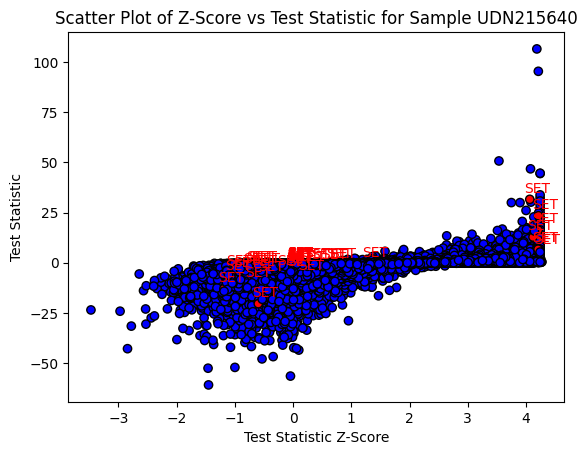

In [24]:
# Filter the DataFrame to include only rows for the sample 'UDN212054'
filtered_df = df[df['Sample'] == 'UDN212054']

# Create a scatter plot with different colors
colors = ['red' if gene == 'HARS1' else 'blue' for gene in filtered_df['associated_gene']]
plt.scatter(filtered_df['z_score'], filtered_df['test_statistic'], c=colors, edgecolor='black')

# Label points where associated_gene is 'HARS1'
for i, row in filtered_df.iterrows():
    if row['associated_gene'] == 'HARS1':
        plt.annotate('HARS1', (row['z_score'], row['test_statistic']),
                     textcoords="offset points", xytext=(5,5), ha='center', color='red')

plt.xlabel('Test Statistic Z-Score')
plt.ylabel('Test Statistic')
plt.title('Scatter Plot of Z-Score vs Test Statistic for Sample UDN212054')
plt.show()

## Plotting Noncyclo TPM Z-score vs Test Statistic Z-Score

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(5, 5, 'SET')

Text(0.5, 0, 'Noncyclo_Z_Score')

Text(0, 0.5, 'Test statistic Z-Score')

Text(0.5, 1.0, 'Scatter Plot of Test statistic Z-Score vs Noncyclo_Z_Score for Sample UDN215640')

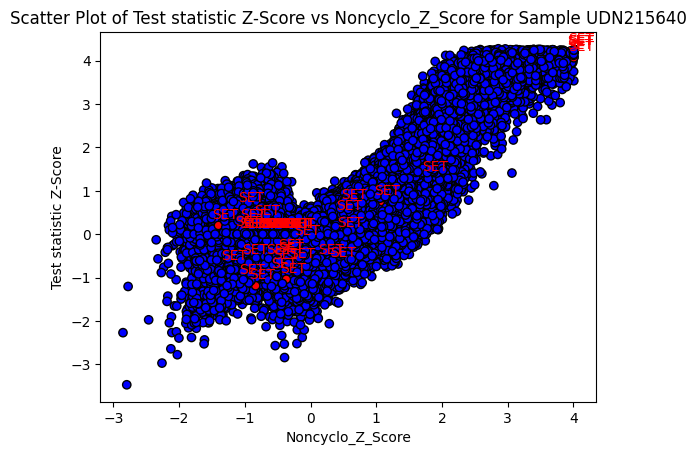

In [25]:
# Filter the DataFrame to include only rows for the sample 'UDN212054'
filtered_df = df[df['Sample'] == 'UDN212054']

# Create a scatter plot
colors = ['red' if gene == 'HARS1' else 'blue' for gene in filtered_df['associated_gene']]
plt.scatter(filtered_df['Noncyclo_Z_Score'], filtered_df['z_score'], c=colors, edgecolor='black')

# Label points where associated_gene is 'UDN687128'
for i, row in filtered_df.iterrows():
    if row['associated_gene'] == 'HARS1':
        plt.annotate('HARS1', (row['Noncyclo_Z_Score'], row['z_score']),
                     textcoords="offset points", xytext=(5,5), ha='center', color='red')

plt.xlabel('Noncyclo_Z_Score')
plt.ylabel('Test statistic Z-Score')
plt.title('Scatter Plot of Test statistic Z-Score vs Noncyclo_Z_Score for Sample UDN212054')
plt.show()

In [26]:
# Find the maximum z-score value
max_z_score = df['z_score'].max()

# Filter the DataFrame to include only rows with the maximum z-score
max_z_score_rows = df[df['z_score'] == max_z_score]

# Calculate the number of rows with the maximum z-score
num_max_z_score_rows = len(max_z_score_rows)

print(f"The number of rows with the maximum z-score is: {num_max_z_score_rows}")

The number of rows with the maximum z-score is: 1


In [27]:
max_z_score_rows

,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,...,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,test_statistic,z_score
1936166,PB.26167.542,UDN318336,3,12,incomplete-splice_match,INPP1,ENST00000392329.7,3prime_fragment,0.174784,NaN,...,INPP1,Inositol polyphosphate-1-phosphatase,3628.0,ENSG00000151689,NaN,NaN,Inpp1 (MGI:104848),False,0.717211,4.318894


In [28]:
# If I use the z-scores to rank, with the max z-score getting a rank of 1. What is the rank of the z-score 
# for isoform_pbid PB.60131.293 in Sample UDN212054

# Filter the DataFrame to include only rows for the sample 'UDN212054'
filtered_df = df[df['Sample'] == 'UDN212054']

# Sort the filtered DataFrame by the z_score in descending order
sorted_df = filtered_df.sort_values(by='z_score', ascending=False)

# Reset the index to create a ranking
sorted_df = sorted_df.reset_index(drop=True)

# Determine the rank of 'PB.60131.293'
isoform_rank = sorted_df[sorted_df['associated_gene'] == 'HARS1'].index[0] + 1  # Adding 1 to convert zero-based index to rank

print(f"The rank of the z-score for gene SET in sample UDN212054 is: {isoform_rank}")

The rank of the z-score for gene SET in sample UDN215640 is: 108


## Rank of positive control

In [29]:
# Define the percentiles to check
percentiles = [99.9, 99.5, 99, 98, 95, 90, 80, 50]

# Filter the DataFrame to include only rows for the sample 'UDN212054'
sample_df = df[df['Sample'] == 'UDN212054']

# Loop through each percentile, calculate and print the rank
for percentile in percentiles:
    # Calculate the percentile of the z-scores within this sample
    percentile_value = np.percentile(sample_df['z_score'], percentile)

    
    # Filter the DataFrame to include only rows with z-scores above this percentile within the sample
    top_percentile_df = sample_df[sample_df['z_score'] > percentile_value]
    
    # Sort the filtered DataFrame by the test statistic in descending order
    sorted_df = top_percentile_df.sort_values(by='test_statistic', ascending=False)
    
    # Reset the index to create a ranking
    sorted_df = sorted_df.reset_index(drop=True)
    
    try:
        # Determine the rank of 'HARS1' in the sorted DataFrame
        hars1_rank = sorted_df[sorted_df['associated_gene'] == 'HARS1'].index[0] + 1  # Adding 1 to convert zero-based index to rank
        print(f"The rank of SET in terms of test statistic among the top {percentile} percentile of z-scores in UDN212054 is: {hars1_rank}")
    except IndexError:
        print(f"SET is not in the top {percentile} percentile of z-scores in UDN212054.")

The rank of SET in terms of test statistic among the top 99.9 percentile of z-scores in UDN215640 is: 62
The rank of SET in terms of test statistic among the top 99.5 percentile of z-scores in UDN215640 is: 8
The rank of SET in terms of test statistic among the top 99 percentile of z-scores in UDN215640 is: 8
The rank of SET in terms of test statistic among the top 98 percentile of z-scores in UDN215640 is: 9
The rank of SET in terms of test statistic among the top 95 percentile of z-scores in UDN215640 is: 9
The rank of SET in terms of test statistic among the top 90 percentile of z-scores in UDN215640 is: 9
The rank of SET in terms of test statistic among the top 80 percentile of z-scores in UDN215640 is: 9
The rank of SET in terms of test statistic among the top 50 percentile of z-scores in UDN215640 is: 9


In [30]:
sample_df.head()
percentile_value
len(top_percentile_df)

,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,...,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,test_statistic,z_score
13,PB.10000.1008,UDN215640,0,2,incomplete-splice_match,DHX9,ENST00000367549.4,3prime_fragment,0.514684,NaN,...,"""DHX9, DDX9, NDHII""",DExH-box helicase 9,1660.0,ENSG00000135829,NaN,NaN,Dhx9 (MGI:108177),False,-1.656574,-0.585789
31,PB.10000.1038,UDN215640,2,4,incomplete-splice_match,DHX9,ENST00000367549.4,3prime_fragment,0.755498,NaN,...,"""DHX9, DDX9, NDHII""",DExH-box helicase 9,1660.0,ENSG00000135829,NaN,NaN,Dhx9 (MGI:108177),False,0.129982,3.438624
49,PB.10000.1072,UDN215640,0,0,incomplete-splice_match,DHX9,ENST00000367549.4,3prime_fragment,NaN,NaN,...,"""DHX9, DDX9, NDHII""",DExH-box helicase 9,1660.0,ENSG00000135829,NaN,NaN,Dhx9 (MGI:108177),False,-1.653841,0.000000
67,PB.10000.1076,UDN215640,2,5,incomplete-splice_match,DHX9,ENST00000367549.4,3prime_fragment,0.514681,NaN,...,"""DHX9, DDX9, NDHII""",DExH-box helicase 9,1660.0,ENSG00000135829,NaN,NaN,Dhx9 (MGI:108177),False,-2.452316,-0.479532
85,PB.10000.1084,UDN215640,2,1,incomplete-splice_match,DHX9,ENST00000367549.4,3prime_fragment,0.945220,NaN,...,"""DHX9, DDX9, NDHII""",DExH-box helicase 9,1660.0,ENSG00000135829,NaN,NaN,Dhx9 (MGI:108177),False,-1.820842,-0.744650


np.float64(0.0)

60425

## Volcano plot replacement

In [31]:
sample_df = df[df['Sample'] == 'UDN212054'][['Isoform_PBid', 'associated_gene', 'Sample', 'cyclo_count', 'noncyclo_count', 'Cyclo_TPM', 'Noncyclo_TPM', 'test_statistic', 'z_score', 'Noncyclo_Z_Score']]
# Filter the DataFrame for rows where 'associated_gene' is 'HARS1'
set_gene_df = sample_df[sample_df['associated_gene'] == 'HARS1']

# Sort the filtered DataFrame in descending order by 'Noncyclo_Z_Score'
set_gene_df.sort_values(by='Noncyclo_Z_Score', ascending=False)

,Isoform_PBid,associated_gene,Sample,cyclo_count,noncyclo_count,Cyclo_TPM,Noncyclo_TPM,test_statistic,z_score,Noncyclo_Z_Score
3325225,PB.98912.630,SET,UDN215640,9,11,1.751376,1.977341,5.824583,4.242641,4.006938
3325045,PB.98912.198,SET,UDN215640,61,79,11.870436,14.200907,23.399727,4.214831,4.006628
3324865,PB.98912.110,SET,UDN215640,22,44,4.281141,7.909366,16.315984,4.210409,4.006220
3325063,PB.98912.204,SET,UDN215640,94,154,18.292148,27.682781,31.580593,4.064851,4.005986
3325081,PB.98912.235,SET,UDN215640,15,33,2.918960,5.932024,12.787605,4.120767,4.000948
3324847,PB.98912.107,SET,UDN215640,16,16,3.113557,2.876133,7.117881,4.207889,3.998435
3325297,PB.98912.681,SET,UDN215640,6,15,1.167584,2.696375,6.741165,4.206942,3.998155
3325675,PB.98912.928,SET,UDN215640,1,7,0.194597,1.258308,-0.570879,1.295488,1.788654
3325891,PB.98912.98,SET,UDN215640,19,35,3.697349,6.291541,-1.011712,0.744908,1.058469
3324883,PB.98912.180,SET,UDN215640,3,7,0.583792,1.258308,-0.884509,0.666010,0.556228


In [32]:
# PB.98912.198 and PB.98912.204	and PB.98912.107 are all part of the exon skipping SET positive controls. Checked in IGV

<Figure size 1000x600 with 0 Axes>

Text(0, 10, 'SET')

Text(0, 10, 'SET')

Text(0, 10, 'SET')

Text(0, 10, 'SET')

Text(0, 10, 'SET')

Text(0, 10, 'SET')

Text(0, 10, 'SET')

Text(0.5, 0, 'Noncyclo_Z_Score')

Text(0, 0.5, 'Test Statistic')

Text(0.5, 1.0, 'Noncyclo_Z_Score vs Test Statistic for Top 5% Genes in UDN215640 based on z-score')

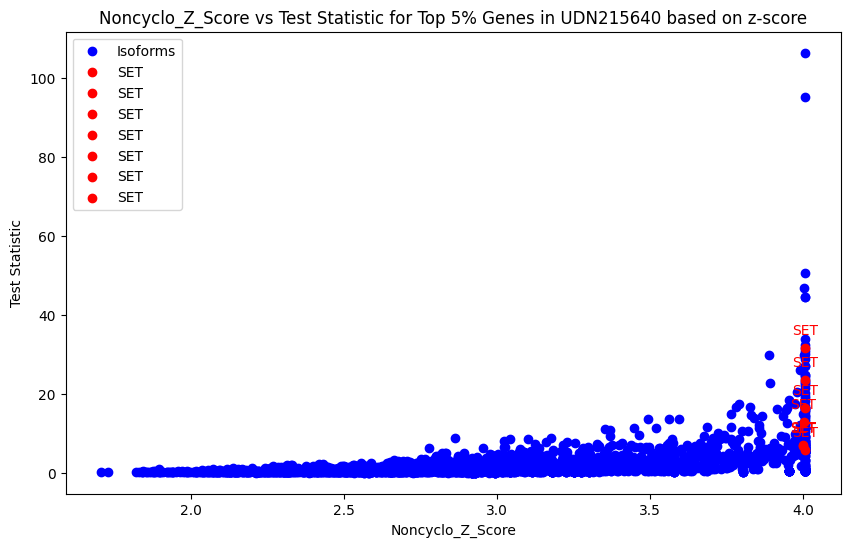

In [33]:
## For the top 5% of isoforms in UDN212054 based on z-score, plot the NormalizedFractionDifference vs test_statistic. 
# Label and color red the HARS1 isoforms.
# Filter the DataFrame to include only rows for the sample 'UDN212054'
sample_df = df[df['Sample'] == 'UDN212054']
sample_df = sample_df[sample_df['Noncyclo_Z_Score'] > 0]

# Calculate the 95th percentile of the z-scores within this sample
percentile_95 = np.percentile(sample_df['z_score'], 95)

# Filter the DataFrame to include only the top 5% isoforms based on z_score
top_5_percent_df = sample_df[sample_df['z_score'] > percentile_95]

# Plot NormalizedFractionDifference vs test_statistic
plt.figure(figsize=(10, 6))
plt.scatter(top_5_percent_df['Noncyclo_Z_Score'], top_5_percent_df['test_statistic'], color='blue', label='Isoforms')

# Highlight and label HARS1 isoforms
for i, row in top_5_percent_df.iterrows():
    if row['associated_gene'] == 'HARS1':
        plt.scatter(row['Noncyclo_Z_Score'], row['test_statistic'], color='red', label='HARS1')
        plt.annotate('HARS1', (row['Noncyclo_Z_Score'], row['test_statistic']),
                     textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.xlabel('Noncyclo_Z_Score')
plt.ylabel('Test Statistic')
plt.title('Noncyclo_Z_Score vs Test Statistic for Top 5% Genes in UDN212054 based on z-score')
plt.legend(loc='best')
plt.show()

In [34]:
# Delete all variables
%reset -f

# Additional cleanup if needed
import gc
gc.collect()

0